In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cbi_toolbox import reconstruct as cbir
from cbi_toolbox import parallel as cbip

import scipy.signal as signal
import scipy.fft as fft

%matplotlib widget

In [2]:

measure = np.load('../out/exp/measure.npy')

measure = measure[:, ::2, ...]

In [3]:
wimage = cbir.dwt_preprocess(measure, drop_hi=2, parallel=True)
del measure

In [4]:
# Resampling

n_time = 100
wimage = signal.resample(wimage, n_time, axis=0)

wimage.shape

(100, 128, 87, 87)

In [2]:

coords = np.mgrid[:64, :64] - 32

wimage = np.zeros((20, 10, 64, 64))
for n in range(wimage.shape[0]):
    wimage[n, 0, ...] = (np.abs(coords[0]) < n+5) * (np.abs(coords[1]) < n+8)


shifts = np.random.randint(0, 20, size=10)
shifts[0] = 0
for n in range(wimage.shape[1]):
    wimage[:, n, ...] = np.roll(wimage[:, 0, ...], -shifts[n], axis=0)
print(shifts)

[ 0  3 14  8  2 19 12  9 16  1]


In [5]:
max_dk = 3

Q_k_dk = np.empty((wimage.shape[0], wimage.shape[1], max_dk + 1))

workers = cbip.max_workers()

wfft = fft.rfft(wimage, axis=0, overwrite_x=False, workers=workers)


for delta_k in range(max_dk+1):
    corr = fft.irfft(wfft * np.conj(np.roll(wfft, -delta_k, axis=1)), axis=0, workers=workers, overwrite_x=True)
    Q_k_dk[..., delta_k] = corr.sum((-1, -2))

del wfft

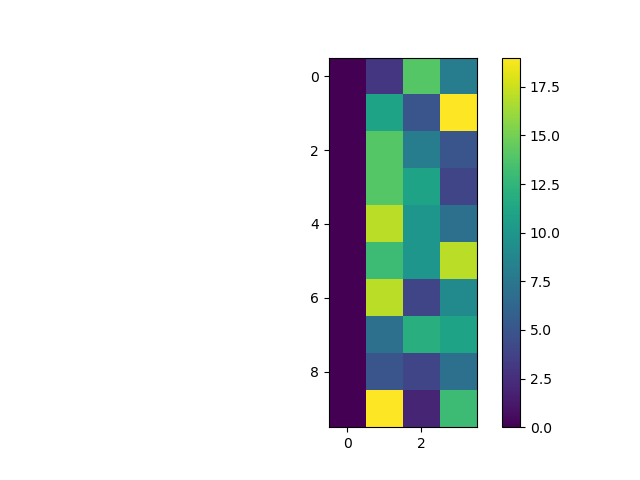

In [7]:
S_k_dk = np.argmax(Q_k_dk, axis=0)

plt.figure()
# plt.imshow(Q_kk[..., 0])
plt.imshow(S_k_dk)
plt.colorbar()
plt.show()